# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [1]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt

In [2]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [3]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [4]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'latin-1')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [5]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

Clean Drives: 170795


In [6]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [7]:
off_play_types

['Pass Completion',
 'Rush',
 'Pass Incompletion',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [8]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)

In [9]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
0,0,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
1,1,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
2,2,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449
3,3,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,26,35,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000
4,4,322430009005,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,11,47,3,6.0,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,2.359414,2012,0.476408


In [10]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [11]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP,play_explosive,play_successful
0,0,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253,False,False
1,1,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460,True,True
2,2,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449,False,True
3,3,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000,False,False
4,4,322430009005,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,3,6.0,9,Rush,Taylor Kelly rush for 9 yards to the NoArz 44 ...,2.359414,2012,0.476408,False,True


In [12]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = tmp.values
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: kickoff_plays.yards_gained[x.Index],axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = pt_tmp.values
        punt_distance["Return"] = punt_distance.apply(lambda x: punt_plays.yards_gained[x.Index],axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    #return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.166667,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,-0.166667,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [13]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.142022,5.050452,5.386628,4.46,5.017309,5.070568,0.141137
1,Virginia Tech,4.857978,4.949548,4.613372,5.54,4.982691,4.929432,-0.141137


In [14]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...
[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...
[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...
[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...
[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...
[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...
[8/

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[228/5670] Updated 5FR Margin for game_id 322782116.
[229/5670] Updating 5FR Margin for game_id 322782229...
[229/5670] Updated 5FR Margin for game_id 322782229.
[230/5670] Updating 5FR Margin for game_id 322790183...
[230/5670] Updated 5FR Margin for game_id 322790183.
[231/5670] Updating 5FR Margin for game_id 322790252...
[231/5670] Updated 5FR Margin for game_id 322790252.
[232/5670] Updating 5FR Margin for game_id 322800002...
[232/5670] Updated 5FR Margin for game_id 322800002.
[233/5670] Updating 5FR Margin for game_id 322800021...
[233/5670] Updated 5FR Margin for game_id 322800021.
[234/5670] Updating 5FR Margin for game_id 322800024...
[234/5670] Updated 5FR Margin for game_id 322800024.
[235/5670] Updating 5FR Margin for game_id 322800025...
[235/5670] Updated 5FR Margin for game_id 322800025.
[236/5670] Updating 5FR Margin for game_id 322800036...
[236/5670] Updated 5FR Margin for game_id 322800036.
[237/5670] Updating 5FR Margin for game_id 322800057...
[237/5670] Updated

[463/5670] Updated 5FR Margin for game_id 323080099.
[464/5670] Updating 5FR Margin for game_id 323080120...
[464/5670] Updated 5FR Margin for game_id 323080120.
[465/5670] Updating 5FR Margin for game_id 323080127...
[465/5670] Updated 5FR Margin for game_id 323080127.
[466/5670] Updating 5FR Margin for game_id 323080135...
[466/5670] Updated 5FR Margin for game_id 323080135.
[467/5670] Updating 5FR Margin for game_id 323080150...
[467/5670] Updated 5FR Margin for game_id 323080150.
[468/5670] Updating 5FR Margin for game_id 323080151...
[468/5670] Updated 5FR Margin for game_id 323080151.
[469/5670] Updating 5FR Margin for game_id 323080152...
[469/5670] Updated 5FR Margin for game_id 323080152.
[470/5670] Updating 5FR Margin for game_id 323080154...
[470/5670] Updated 5FR Margin for game_id 323080154.
[471/5670] Updating 5FR Margin for game_id 323080194...
[471/5670] Updated 5FR Margin for game_id 323080194.
[472/5670] Updating 5FR Margin for game_id 323080204...
[472/5670] Updated 

[703/5670] Updated 5FR Margin for game_id 332430152.
[704/5670] Updating 5FR Margin for game_id 332430158...
[704/5670] Updated 5FR Margin for game_id 332430158.
[705/5670] Updating 5FR Margin for game_id 332430167...
[705/5670] Updated 5FR Margin for game_id 332430167.
[706/5670] Updating 5FR Margin for game_id 332430194...
[706/5670] Updated 5FR Margin for game_id 332430194.
[707/5670] Updating 5FR Margin for game_id 332430197...
[707/5670] Updated 5FR Margin for game_id 332430197.
[708/5670] Updating 5FR Margin for game_id 332430201...
[708/5670] Updated 5FR Margin for game_id 332430201.
[709/5670] Updating 5FR Margin for game_id 332430213...
[709/5670] Updated 5FR Margin for game_id 332430213.
[710/5670] Updating 5FR Margin for game_id 332430228...
[710/5670] Updated 5FR Margin for game_id 332430228.
[711/5670] Updating 5FR Margin for game_id 332430245...
[711/5670] Updated 5FR Margin for game_id 332430245.
[712/5670] Updating 5FR Margin for game_id 332430251...
[712/5670] Updated 

[941/5670] Updated 5FR Margin for game_id 332782294.
[942/5670] Updating 5FR Margin for game_id 332782305...
[942/5670] Updated 5FR Margin for game_id 332782305.
[943/5670] Updating 5FR Margin for game_id 332782309...
[943/5670] Updated 5FR Margin for game_id 332782309.
[944/5670] Updating 5FR Margin for game_id 332782390...
[944/5670] Updated 5FR Margin for game_id 332782390.
[945/5670] Updating 5FR Margin for game_id 332782393...
[945/5670] Updated 5FR Margin for game_id 332782393.
[946/5670] Updating 5FR Margin for game_id 332782426...
[946/5670] Updated 5FR Margin for game_id 332782426.
[947/5670] Updating 5FR Margin for game_id 332782567...
[947/5670] Updated 5FR Margin for game_id 332782567.
[948/5670] Updating 5FR Margin for game_id 332782572...
[948/5670] Updated 5FR Margin for game_id 332782572.
[949/5670] Updating 5FR Margin for game_id 332782579...
[949/5670] Updated 5FR Margin for game_id 332782579.
[950/5670] Updating 5FR Margin for game_id 332782633...
[950/5670] Updated 

[1178/5670] Updating 5FR Margin for game_id 333130197...
[1178/5670] Updated 5FR Margin for game_id 333130197.
[1179/5670] Updating 5FR Margin for game_id 333130221...
[1179/5670] Updated 5FR Margin for game_id 333130221.
[1180/5670] Updating 5FR Margin for game_id 333130245...
[1180/5670] Updated 5FR Margin for game_id 333130245.
[1181/5670] Updating 5FR Margin for game_id 333130249...
[1181/5670] Updated 5FR Margin for game_id 333130249.
[1182/5670] Updating 5FR Margin for game_id 333130254...
[1182/5670] Updated 5FR Margin for game_id 333130254.
[1183/5670] Updating 5FR Margin for game_id 333130264...
[1183/5670] Updated 5FR Margin for game_id 333130264.
[1184/5670] Updating 5FR Margin for game_id 333130275...
[1184/5670] Updated 5FR Margin for game_id 333130275.
[1185/5670] Updating 5FR Margin for game_id 333130276...
[1185/5670] Updated 5FR Margin for game_id 333130276.
[1186/5670] Updating 5FR Margin for game_id 333130277...
[1186/5670] Updated 5FR Margin for game_id 333130277.
[

[1414/5670] Updating 5FR Margin for game_id 400547682...
[1414/5670] Updated 5FR Margin for game_id 400547682.
[1415/5670] Updating 5FR Margin for game_id 400547683...
[1415/5670] Updated 5FR Margin for game_id 400547683.
[1416/5670] Updating 5FR Margin for game_id 400547684...
[1416/5670] Updated 5FR Margin for game_id 400547684.
[1417/5670] Updating 5FR Margin for game_id 400547685...
[1417/5670] Updated 5FR Margin for game_id 400547685.
[1418/5670] Updating 5FR Margin for game_id 400547686...
[1418/5670] Updated 5FR Margin for game_id 400547686.
[1419/5670] Updating 5FR Margin for game_id 400547687...
[1419/5670] Updated 5FR Margin for game_id 400547687.
[1420/5670] Updating 5FR Margin for game_id 400547688...
[1420/5670] Updated 5FR Margin for game_id 400547688.
[1421/5670] Updating 5FR Margin for game_id 400547689...
[1421/5670] Updated 5FR Margin for game_id 400547689.
[1422/5670] Updating 5FR Margin for game_id 400547690...
[1422/5670] Updated 5FR Margin for game_id 400547690.
[

[1647/5670] Updated 5FR Margin for game_id 400547945.
[1648/5670] Updating 5FR Margin for game_id 400547946...
[1648/5670] Updated 5FR Margin for game_id 400547946.
[1649/5670] Updating 5FR Margin for game_id 400547947...
[1649/5670] Updated 5FR Margin for game_id 400547947.
[1650/5670] Updating 5FR Margin for game_id 400547948...
[1650/5670] Updated 5FR Margin for game_id 400547948.
[1651/5670] Updating 5FR Margin for game_id 400547949...
[1651/5670] Updated 5FR Margin for game_id 400547949.
[1652/5670] Updating 5FR Margin for game_id 400547950...
[1652/5670] Updated 5FR Margin for game_id 400547950.
[1653/5670] Updating 5FR Margin for game_id 400547951...
[1653/5670] Updated 5FR Margin for game_id 400547951.
[1654/5670] Updating 5FR Margin for game_id 400547953...
[1654/5670] Updated 5FR Margin for game_id 400547953.
[1655/5670] Updating 5FR Margin for game_id 400547954...
[1655/5670] Updated 5FR Margin for game_id 400547954.
[1656/5670] Updating 5FR Margin for game_id 400547955...
[

[1887/5670] Updating 5FR Margin for game_id 400548238...
[1887/5670] Updated 5FR Margin for game_id 400548238.
[1888/5670] Updating 5FR Margin for game_id 400548239...
[1888/5670] Updated 5FR Margin for game_id 400548239.
[1889/5670] Updating 5FR Margin for game_id 400548240...
[1889/5670] Updated 5FR Margin for game_id 400548240.
[1890/5670] Updating 5FR Margin for game_id 400548241...
[1890/5670] Updated 5FR Margin for game_id 400548241.
[1891/5670] Updating 5FR Margin for game_id 400548242...
[1891/5670] Updated 5FR Margin for game_id 400548242.
[1892/5670] Updating 5FR Margin for game_id 400548243...
[1892/5670] Updated 5FR Margin for game_id 400548243.
[1893/5670] Updating 5FR Margin for game_id 400548244...
[1893/5670] Updated 5FR Margin for game_id 400548244.
[1894/5670] Updating 5FR Margin for game_id 400548245...
[1894/5670] Updated 5FR Margin for game_id 400548245.
[1895/5670] Updating 5FR Margin for game_id 400548246...
[1895/5670] Updated 5FR Margin for game_id 400548246.
[

[2128/5670] Updating 5FR Margin for game_id 400603895...
[2128/5670] Updated 5FR Margin for game_id 400603895.
[2129/5670] Updating 5FR Margin for game_id 400603896...
[2129/5670] Updated 5FR Margin for game_id 400603896.
[2130/5670] Updating 5FR Margin for game_id 400603897...
[2130/5670] Updated 5FR Margin for game_id 400603897.
[2131/5670] Updating 5FR Margin for game_id 400603898...
[2131/5670] Updated 5FR Margin for game_id 400603898.
[2132/5670] Updating 5FR Margin for game_id 400603899...
[2132/5670] Updated 5FR Margin for game_id 400603899.
[2133/5670] Updating 5FR Margin for game_id 400603900...
[2133/5670] Updated 5FR Margin for game_id 400603900.
[2134/5670] Updating 5FR Margin for game_id 400603901...
[2134/5670] Updated 5FR Margin for game_id 400603901.
[2135/5670] Updating 5FR Margin for game_id 400603902...
[2135/5670] Updated 5FR Margin for game_id 400603902.
[2136/5670] Updating 5FR Margin for game_id 400603903...
[2136/5670] Updated 5FR Margin for game_id 400603903.
[

[2366/5670] Updating 5FR Margin for game_id 400763426...
[2366/5670] Updated 5FR Margin for game_id 400763426.
[2367/5670] Updating 5FR Margin for game_id 400763427...
[2367/5670] Updated 5FR Margin for game_id 400763427.
[2368/5670] Updating 5FR Margin for game_id 400763428...
[2368/5670] Updated 5FR Margin for game_id 400763428.
[2369/5670] Updating 5FR Margin for game_id 400763429...
[2369/5670] Updated 5FR Margin for game_id 400763429.
[2370/5670] Updating 5FR Margin for game_id 400763430...
[2370/5670] Updated 5FR Margin for game_id 400763430.
[2371/5670] Updating 5FR Margin for game_id 400763431...
[2371/5670] Updated 5FR Margin for game_id 400763431.
[2372/5670] Updating 5FR Margin for game_id 400763432...
[2372/5670] Updated 5FR Margin for game_id 400763432.
[2373/5670] Updating 5FR Margin for game_id 400763433...
[2373/5670] Updated 5FR Margin for game_id 400763433.
[2374/5670] Updating 5FR Margin for game_id 400763434...
[2374/5670] Updated 5FR Margin for game_id 400763434.
[

[2604/5670] Updating 5FR Margin for game_id 400764903...
[2604/5670] Updated 5FR Margin for game_id 400764903.
[2605/5670] Updating 5FR Margin for game_id 400764904...
[2605/5670] Updated 5FR Margin for game_id 400764904.
[2606/5670] Updating 5FR Margin for game_id 400764905...
[2606/5670] Updated 5FR Margin for game_id 400764905.
[2607/5670] Updating 5FR Margin for game_id 400764906...
[2607/5670] Updated 5FR Margin for game_id 400764906.
[2608/5670] Updating 5FR Margin for game_id 400764907...
[2608/5670] Updated 5FR Margin for game_id 400764907.
[2609/5670] Updating 5FR Margin for game_id 400764908...
[2609/5670] Updated 5FR Margin for game_id 400764908.
[2610/5670] Updating 5FR Margin for game_id 400764909...
[2610/5670] Updated 5FR Margin for game_id 400764909.
[2611/5670] Updating 5FR Margin for game_id 400764910...
[2611/5670] Updated 5FR Margin for game_id 400764910.
[2612/5670] Updating 5FR Margin for game_id 400764911...
[2612/5670] Updated 5FR Margin for game_id 400764911.
[

[2840/5670] Updated 5FR Margin for game_id 400868970.
[2841/5670] Updating 5FR Margin for game_id 400868971...
[2841/5670] Updated 5FR Margin for game_id 400868971.
[2842/5670] Updating 5FR Margin for game_id 400868972...
[2842/5670] Updated 5FR Margin for game_id 400868972.
[2843/5670] Updating 5FR Margin for game_id 400868973...
[2843/5670] Updated 5FR Margin for game_id 400868973.
[2844/5670] Updating 5FR Margin for game_id 400868974...
[2844/5670] Updated 5FR Margin for game_id 400868974.
[2845/5670] Updating 5FR Margin for game_id 400868975...
[2845/5670] Updated 5FR Margin for game_id 400868975.
[2846/5670] Updating 5FR Margin for game_id 400868976...
[2846/5670] Updated 5FR Margin for game_id 400868976.
[2847/5670] Updating 5FR Margin for game_id 400868977...
[2847/5670] Updated 5FR Margin for game_id 400868977.
[2848/5670] Updating 5FR Margin for game_id 400868978...
[2848/5670] Updated 5FR Margin for game_id 400868978.
[2849/5670] Updating 5FR Margin for game_id 400868979...
[

[3080/5670] Updating 5FR Margin for game_id 400869269...
[3080/5670] Updated 5FR Margin for game_id 400869269.
[3081/5670] Updating 5FR Margin for game_id 400869270...
[3081/5670] Updated 5FR Margin for game_id 400869270.
[3082/5670] Updating 5FR Margin for game_id 400869273...
[3082/5670] Updated 5FR Margin for game_id 400869273.
[3083/5670] Updating 5FR Margin for game_id 400869277...
[3083/5670] Updated 5FR Margin for game_id 400869277.
[3084/5670] Updating 5FR Margin for game_id 400869278...
[3084/5670] Updated 5FR Margin for game_id 400869278.
[3085/5670] Updating 5FR Margin for game_id 400869280...
[3085/5670] Updated 5FR Margin for game_id 400869280.
[3086/5670] Updating 5FR Margin for game_id 400869281...
[3086/5670] Updated 5FR Margin for game_id 400869281.
[3087/5670] Updating 5FR Margin for game_id 400869283...
[3087/5670] Updated 5FR Margin for game_id 400869283.
[3088/5670] Updating 5FR Margin for game_id 400869284...
[3088/5670] Updated 5FR Margin for game_id 400869284.
[

[3320/5670] Updated 5FR Margin for game_id 400869560.
[3321/5670] Updating 5FR Margin for game_id 400869561...
[3321/5670] Updated 5FR Margin for game_id 400869561.
[3322/5670] Updating 5FR Margin for game_id 400869562...
[3322/5670] Updated 5FR Margin for game_id 400869562.
[3323/5670] Updating 5FR Margin for game_id 400869563...
[3323/5670] Updated 5FR Margin for game_id 400869563.
[3324/5670] Updating 5FR Margin for game_id 400869564...
[3324/5670] Updated 5FR Margin for game_id 400869564.
[3325/5670] Updating 5FR Margin for game_id 400869565...
[3325/5670] Updated 5FR Margin for game_id 400869565.
[3326/5670] Updating 5FR Margin for game_id 400869566...
[3326/5670] Updated 5FR Margin for game_id 400869566.
[3327/5670] Updating 5FR Margin for game_id 400869567...
[3327/5670] Updated 5FR Margin for game_id 400869567.
[3328/5670] Updating 5FR Margin for game_id 400869568...
[3328/5670] Updated 5FR Margin for game_id 400869568.
[3329/5670] Updating 5FR Margin for game_id 400869570...
[

[3555/5670] Updating 5FR Margin for game_id 400933909...
[3555/5670] Updated 5FR Margin for game_id 400933909.
[3556/5670] Updating 5FR Margin for game_id 400933910...
[3556/5670] Updated 5FR Margin for game_id 400933910.
[3557/5670] Updating 5FR Margin for game_id 400933911...
[3557/5670] Updated 5FR Margin for game_id 400933911.
[3558/5670] Updating 5FR Margin for game_id 400933912...
[3558/5670] Updated 5FR Margin for game_id 400933912.
[3559/5670] Updating 5FR Margin for game_id 400933913...
[3559/5670] Updated 5FR Margin for game_id 400933913.
[3560/5670] Updating 5FR Margin for game_id 400933914...
[3560/5670] Updated 5FR Margin for game_id 400933914.
[3561/5670] Updating 5FR Margin for game_id 400933915...
[3561/5670] Updated 5FR Margin for game_id 400933915.
[3562/5670] Updating 5FR Margin for game_id 400933916...
[3562/5670] Updated 5FR Margin for game_id 400933916.
[3563/5670] Updating 5FR Margin for game_id 400933917...
[3563/5670] Updated 5FR Margin for game_id 400933917.
[

[3794/5670] Updating 5FR Margin for game_id 400935380...
[3794/5670] Updated 5FR Margin for game_id 400935380.
[3795/5670] Updating 5FR Margin for game_id 400935381...
[3795/5670] Updated 5FR Margin for game_id 400935381.
[3796/5670] Updating 5FR Margin for game_id 400935382...
[3796/5670] Updated 5FR Margin for game_id 400935382.
[3797/5670] Updating 5FR Margin for game_id 400935383...
[3797/5670] Updated 5FR Margin for game_id 400935383.
[3798/5670] Updating 5FR Margin for game_id 400935384...
[3798/5670] Updated 5FR Margin for game_id 400935384.
[3799/5670] Updating 5FR Margin for game_id 400935385...
[3799/5670] Updated 5FR Margin for game_id 400935385.
[3800/5670] Updating 5FR Margin for game_id 400935386...
[3800/5670] Updated 5FR Margin for game_id 400935386.
[3801/5670] Updating 5FR Margin for game_id 400935387...
[3801/5670] Updated 5FR Margin for game_id 400935387.
[3802/5670] Updating 5FR Margin for game_id 400935388...
[3802/5670] Updated 5FR Margin for game_id 400935388.
[

[4031/5670] Updating 5FR Margin for game_id 400941841...
[4031/5670] Updated 5FR Margin for game_id 400941841.
[4032/5670] Updating 5FR Margin for game_id 400941842...
[4032/5670] Updated 5FR Margin for game_id 400941842.
[4033/5670] Updating 5FR Margin for game_id 400941843...
[4033/5670] Updated 5FR Margin for game_id 400941843.
[4034/5670] Updating 5FR Margin for game_id 400941844...
[4034/5670] Updated 5FR Margin for game_id 400941844.
[4035/5670] Updating 5FR Margin for game_id 400941845...
[4035/5670] Updated 5FR Margin for game_id 400941845.
[4036/5670] Updating 5FR Margin for game_id 400941846...
[4036/5670] Updated 5FR Margin for game_id 400941846.
[4037/5670] Updating 5FR Margin for game_id 400941847...
[4037/5670] Updated 5FR Margin for game_id 400941847.
[4038/5670] Updating 5FR Margin for game_id 400941848...
[4038/5670] Updated 5FR Margin for game_id 400941848.
[4039/5670] Updating 5FR Margin for game_id 400941849...
[4039/5670] Updated 5FR Margin for game_id 400941849.
[

[4268/5670] Updating 5FR Margin for game_id 401012320...
[4268/5670] Updated 5FR Margin for game_id 401012320.
[4269/5670] Updating 5FR Margin for game_id 401012321...
[4269/5670] Updated 5FR Margin for game_id 401012321.
[4270/5670] Updating 5FR Margin for game_id 401012322...
[4270/5670] Updated 5FR Margin for game_id 401012322.
[4271/5670] Updating 5FR Margin for game_id 401012323...
[4271/5670] Updated 5FR Margin for game_id 401012323.
[4272/5670] Updating 5FR Margin for game_id 401012324...
[4272/5670] Updated 5FR Margin for game_id 401012324.
[4273/5670] Updating 5FR Margin for game_id 401012325...
[4273/5670] Updated 5FR Margin for game_id 401012325.
[4274/5670] Updating 5FR Margin for game_id 401012326...
[4274/5670] Updated 5FR Margin for game_id 401012326.
[4275/5670] Updating 5FR Margin for game_id 401012327...
[4275/5670] Updated 5FR Margin for game_id 401012327.
[4276/5670] Updating 5FR Margin for game_id 401012328...
[4276/5670] Updated 5FR Margin for game_id 401012328.
[

[4503/5670] Updating 5FR Margin for game_id 401013105...
[4503/5670] Updated 5FR Margin for game_id 401013105.
[4504/5670] Updating 5FR Margin for game_id 401013109...
[4504/5670] Updated 5FR Margin for game_id 401013109.
[4505/5670] Updating 5FR Margin for game_id 401013110...
[4505/5670] Updated 5FR Margin for game_id 401013110.
[4506/5670] Updating 5FR Margin for game_id 401013111...
[4506/5670] Updated 5FR Margin for game_id 401013111.
[4507/5670] Updating 5FR Margin for game_id 401013112...
[4507/5670] Updated 5FR Margin for game_id 401013112.
[4508/5670] Updating 5FR Margin for game_id 401013113...
[4508/5670] Updated 5FR Margin for game_id 401013113.
[4509/5670] Updating 5FR Margin for game_id 401013114...
[4509/5670] Updated 5FR Margin for game_id 401013114.
[4510/5670] Updating 5FR Margin for game_id 401013117...
[4510/5670] Updated 5FR Margin for game_id 401013117.
[4511/5670] Updating 5FR Margin for game_id 401013119...
[4511/5670] Updated 5FR Margin for game_id 401013119.
[

[4742/5670] Updating 5FR Margin for game_id 401019501...
[4742/5670] Updated 5FR Margin for game_id 401019501.
[4743/5670] Updating 5FR Margin for game_id 401019502...
[4743/5670] Updated 5FR Margin for game_id 401019502.
[4744/5670] Updating 5FR Margin for game_id 401019503...
[4744/5670] Updated 5FR Margin for game_id 401019503.
[4745/5670] Updating 5FR Margin for game_id 401019504...
[4745/5670] Updated 5FR Margin for game_id 401019504.
[4746/5670] Updating 5FR Margin for game_id 401019505...
[4746/5670] Updated 5FR Margin for game_id 401019505.
[4747/5670] Updating 5FR Margin for game_id 401019506...
[4747/5670] Updated 5FR Margin for game_id 401019506.
[4748/5670] Updating 5FR Margin for game_id 401019507...
[4748/5670] Updated 5FR Margin for game_id 401019507.
[4749/5670] Updating 5FR Margin for game_id 401019508...
[4749/5670] Updated 5FR Margin for game_id 401019508.
[4750/5670] Updating 5FR Margin for game_id 401019509...
[4750/5670] Updated 5FR Margin for game_id 401019509.
[

[4981/5670] Updating 5FR Margin for game_id 401110812...
[4981/5670] Updated 5FR Margin for game_id 401110812.
[4982/5670] Updating 5FR Margin for game_id 401110813...
[4982/5670] Updated 5FR Margin for game_id 401110813.
[4983/5670] Updating 5FR Margin for game_id 401110814...
[4983/5670] Updated 5FR Margin for game_id 401110814.
[4984/5670] Updating 5FR Margin for game_id 401110815...
[4984/5670] Updated 5FR Margin for game_id 401110815.
[4985/5670] Updating 5FR Margin for game_id 401110816...
[4985/5670] Updated 5FR Margin for game_id 401110816.
[4986/5670] Updating 5FR Margin for game_id 401110817...
[4986/5670] Updated 5FR Margin for game_id 401110817.
[4987/5670] Updating 5FR Margin for game_id 401110818...
[4987/5670] Updated 5FR Margin for game_id 401110818.
[4988/5670] Updating 5FR Margin for game_id 401110819...
[4988/5670] Updated 5FR Margin for game_id 401110819.
[4989/5670] Updating 5FR Margin for game_id 401110820...
[4989/5670] Updated 5FR Margin for game_id 401110820.
[

[5215/5670] Updated 5FR Margin for game_id 401112453.
[5216/5670] Updating 5FR Margin for game_id 401112456...
[5216/5670] Updated 5FR Margin for game_id 401112456.
[5217/5670] Updating 5FR Margin for game_id 401112457...
[5217/5670] Updated 5FR Margin for game_id 401112457.
[5218/5670] Updating 5FR Margin for game_id 401112458...
[5218/5670] Updated 5FR Margin for game_id 401112458.
[5219/5670] Updating 5FR Margin for game_id 401112459...
[5219/5670] Updated 5FR Margin for game_id 401112459.
[5220/5670] Updating 5FR Margin for game_id 401112460...
[5220/5670] Updated 5FR Margin for game_id 401112460.
[5221/5670] Updating 5FR Margin for game_id 401112461...
[5221/5670] Updated 5FR Margin for game_id 401112461.
[5222/5670] Updating 5FR Margin for game_id 401112462...
[5222/5670] Updated 5FR Margin for game_id 401112462.
[5223/5670] Updating 5FR Margin for game_id 401112463...
[5223/5670] Updated 5FR Margin for game_id 401112463.
[5224/5670] Updating 5FR Margin for game_id 401112465...
[

[5454/5670] Updated 5FR Margin for game_id 401114358.
[5455/5670] Updating 5FR Margin for game_id 401117213...
[5455/5670] Updated 5FR Margin for game_id 401117213.
[5456/5670] Updating 5FR Margin for game_id 401117214...
[5456/5670] Updated 5FR Margin for game_id 401117214.
[5457/5670] Updating 5FR Margin for game_id 401117215...
[5457/5670] Updated 5FR Margin for game_id 401117215.
[5458/5670] Updating 5FR Margin for game_id 401117216...
[5458/5670] Updated 5FR Margin for game_id 401117216.
[5459/5670] Updating 5FR Margin for game_id 401117218...
[5459/5670] Updated 5FR Margin for game_id 401117218.
[5460/5670] Updating 5FR Margin for game_id 401117500...
[5460/5670] Updated 5FR Margin for game_id 401117500.
[5461/5670] Updating 5FR Margin for game_id 401117501...
[5461/5670] Updated 5FR Margin for game_id 401117501.
[5462/5670] Updating 5FR Margin for game_id 401117502...
[5462/5670] Updated 5FR Margin for game_id 401117502.
[5463/5670] Updating 5FR Margin for game_id 401117506...
[

[Local] Wrote updated box scores to file.


In [15]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,DefSR,OffER,YPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.382716,0.074627,6.029851,...,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.656305,0.860864,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.492537,0.061728,4.370370,...,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.656305,0.860864,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.271186,0.080645,5.129032,...,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.597540,0.783782,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.435484,0.152542,5.813559,...,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.597540,0.783782,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.510417,0.134328,6.119403,...,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.335597,0.440197,0.499553


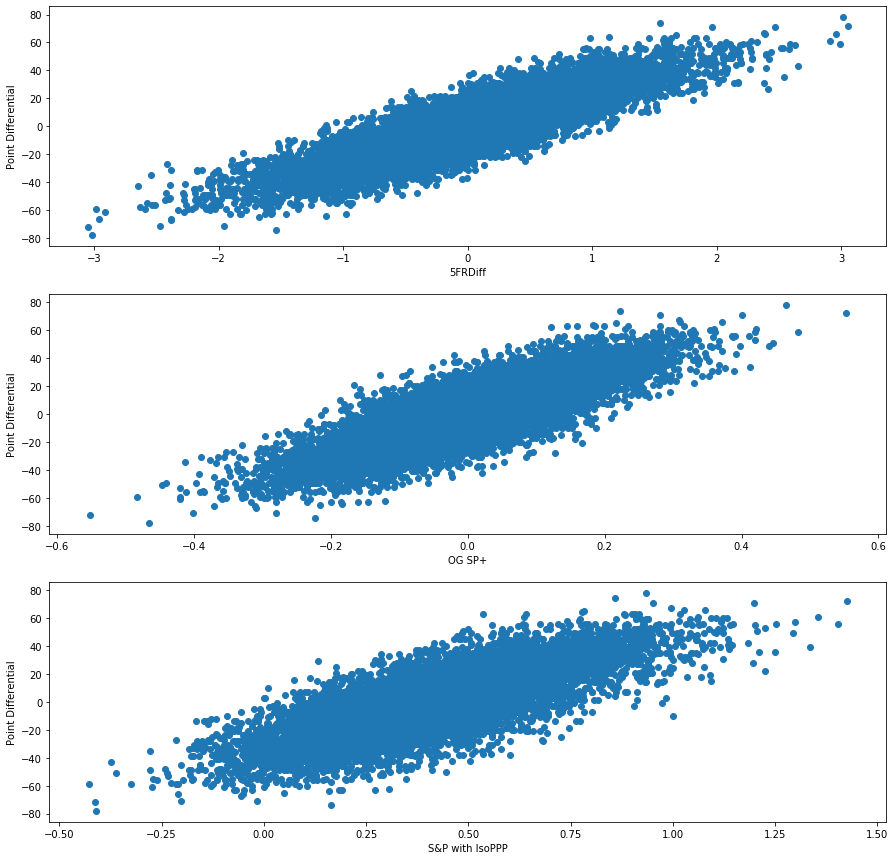

In [16]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [17]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.911990,0.759463
S&PIsoPPPDiff,0.911990,1.000000,0.816783
PtsDiff,0.759463,0.816783,1.000000


In [18]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,DefSR,OffER,YPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.382716,0.074627,6.029851,...,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.656305,0.860864,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.492537,0.061728,4.370370,...,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.656305,0.860864,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.271186,0.080645,5.129032,...,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.597540,0.783782,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.435484,0.152542,5.813559,...,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.597540,0.783782,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.510417,0.134328,6.119403,...,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.335597,0.440197,0.499553


In [19]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [20]:
# outliers

In [21]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,DefSR,OffER,YPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.382716,0.074627,6.029851,...,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.656305,0.860864,1.907384
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.435484,0.152542,5.813559,...,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.597540,0.783782,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.510417,0.134328,6.119403,...,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.335597,0.440197,0.499553
5,Ball State,2012,322432050,37.0,11.0,0.979920,0.510417,0.447761,0.083333,6.291667,...,-0.010417,0.416667,0.541667,0.095238,0.095238,0.750000,5.255388,0.335597,0.440197,0.499553
7,Connecticut,2012,322430041,37.0,37.0,0.999995,0.385714,0.148936,0.128571,5.614286,...,0.042553,1.000000,0.857143,-0.045455,-0.045455,1.000000,6.011375,1.605919,2.106457,1.680314


In [22]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [23]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 25.21425x + 0.04574
Mean Pred Score: 0.3464955753624591
Pred Std Dev: 18.77498896946417
Mean Abs Error: 8.457807530484034
Mdn Abs Error: 7.151491006498233
R-squared: 0.7553341005918629



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.767886,0.575177,0.491706,0.797275,0.599637,0.600347,0.982896,0.539070,0.779407,...,0.514192,0.444511,0.267320,0.164487,0.071458,0.127004,0.166284,0.899007,0.869167,0.869167
OffSRDiff,0.767886,1.000000,0.496942,0.297930,0.702044,0.387984,0.427560,0.762047,0.755959,0.724970,...,0.525223,0.410160,0.199210,0.106206,0.003933,0.048013,0.092354,0.920158,0.966034,0.966034
OffERDiff,0.575177,0.496942,1.000000,0.169160,0.499896,0.279665,0.322314,0.566602,0.364442,0.806278,...,0.164703,0.189929,0.112873,0.040584,0.015014,0.045983,0.029912,0.533936,0.558317,0.558317
FPDiff,0.491706,0.297930,0.169160,1.000000,0.608315,0.100074,0.065061,0.467323,0.078369,0.249759,...,0.245007,0.244391,0.312046,0.241424,0.239650,0.252972,0.174883,0.564186,0.366919,0.366919
OppRateDiff,0.797275,0.702044,0.499896,0.608315,1.000000,0.209955,0.198910,0.795398,0.310011,0.668798,...,0.478544,0.413729,0.261237,0.183545,0.056996,0.106688,0.222278,0.827190,0.770266,0.770266
OppEffDiff,0.599637,0.387984,0.279665,0.100074,0.209955,1.000000,0.744628,0.600482,0.485450,0.417146,...,0.281219,0.234978,0.114086,0.044885,0.029466,0.054874,0.346397,0.481017,0.499509,0.499509
OppPPDDiff,0.600347,0.427560,0.322314,0.065061,0.198910,0.744628,1.000000,0.611369,0.544604,0.467412,...,0.306437,0.269920,0.098765,0.049907,0.007401,0.033782,0.025375,0.541559,0.576948,0.576948
PPDDiff,0.982896,0.762047,0.566602,0.467323,0.795398,0.600482,0.611369,1.000000,0.533216,0.768411,...,0.516775,0.437312,0.268057,0.162283,0.065906,0.127686,0.151995,0.890460,0.866139,0.866139
OppSRDiff,0.539070,0.755959,0.364442,0.078369,0.310011,0.485450,0.544604,0.533216,1.000000,0.553821,...,0.352521,0.277336,0.125778,0.045486,-0.009088,0.011621,-0.047788,0.681455,0.753339,0.753339
YPPDiff,0.779407,0.724970,0.806278,0.249759,0.668798,0.417146,0.467412,0.768411,0.553821,1.000000,...,0.416561,0.401957,0.169649,0.086546,0.005623,0.047023,0.066192,0.763771,0.795950,0.795950


In [24]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.745214,0.767886,0.715887,0.905757,0.491706,0.480921,0.899007,0.869167,0.869167
ActPts,0.745214,1.000000,0.572326,0.511710,0.668280,0.380578,0.367942,0.670775,0.643902,0.643902
Eff,0.767886,0.572326,1.000000,0.639173,0.801033,0.297930,0.269625,0.920158,0.966034,0.966034
Expl,0.715887,0.511710,0.639173,1.000000,0.683606,0.233441,0.212772,0.691132,0.717412,0.717412
FinDrv,0.905757,0.668280,0.801033,0.683606,1.000000,0.416175,0.425267,0.921481,0.920462,0.920462
FldPos,0.491706,0.380578,0.297930,0.233441,0.416175,1.000000,0.361930,0.564186,0.366919,0.366919
Trnovr,0.480921,0.367942,0.269625,0.212772,0.425267,0.361930,1.000000,0.480180,0.379352,0.379352
5FR,0.899007,0.670775,0.920158,0.691132,0.921481,0.564186,0.480180,1.000000,0.971235,0.971235
5FRDiff,0.869167,0.643902,0.966034,0.717412,0.920462,0.366919,0.379352,0.971235,1.000000,1.000000
PredPtsDiff,0.869167,0.643902,0.966034,0.717412,0.920462,0.366919,0.379352,0.971235,1.000000,1.000000


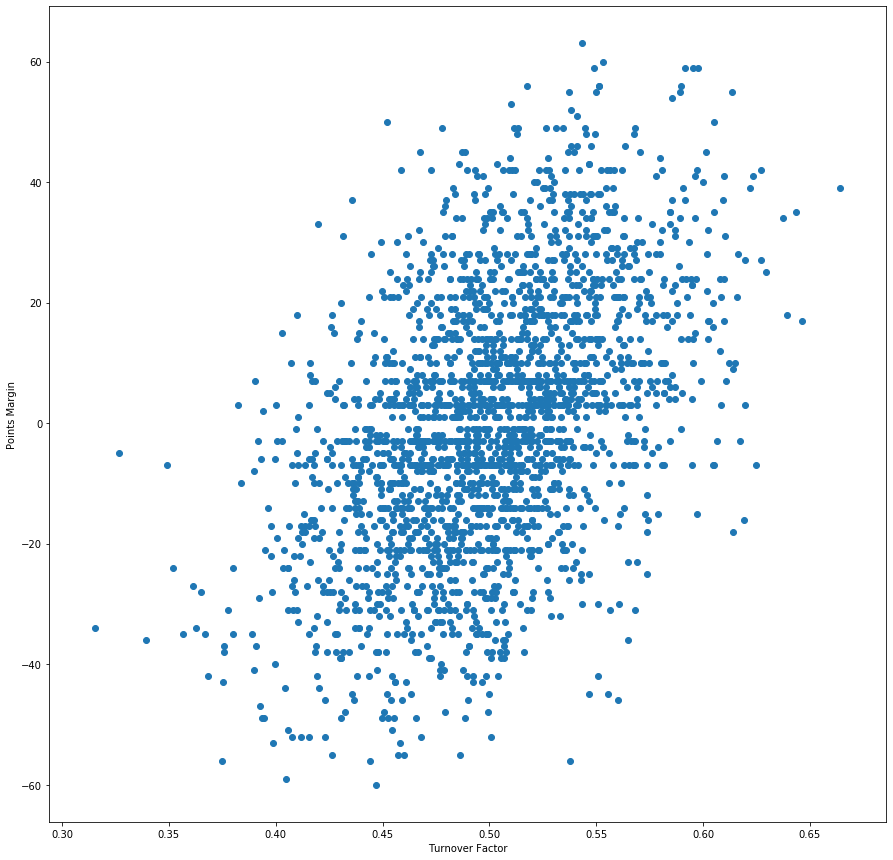

In [25]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

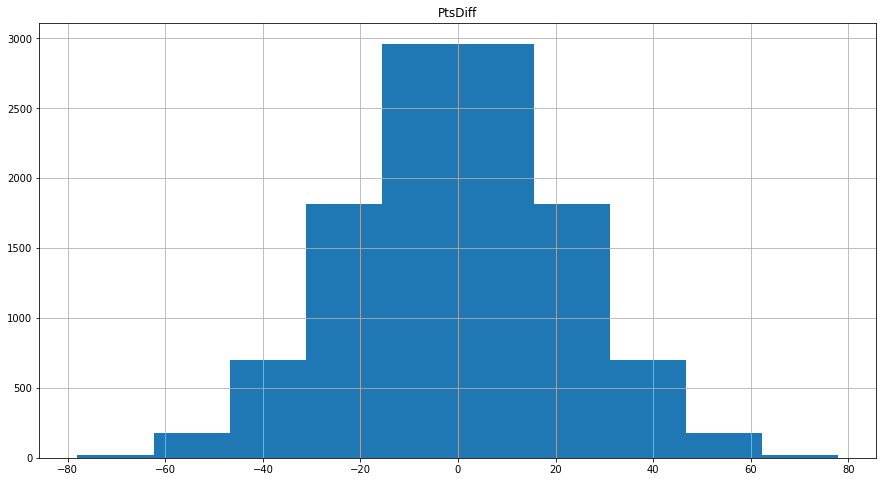

In [26]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

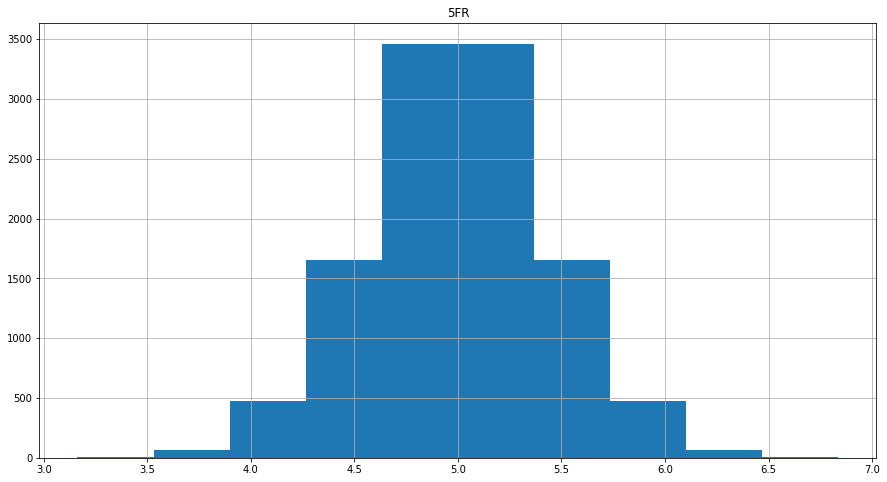

In [27]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

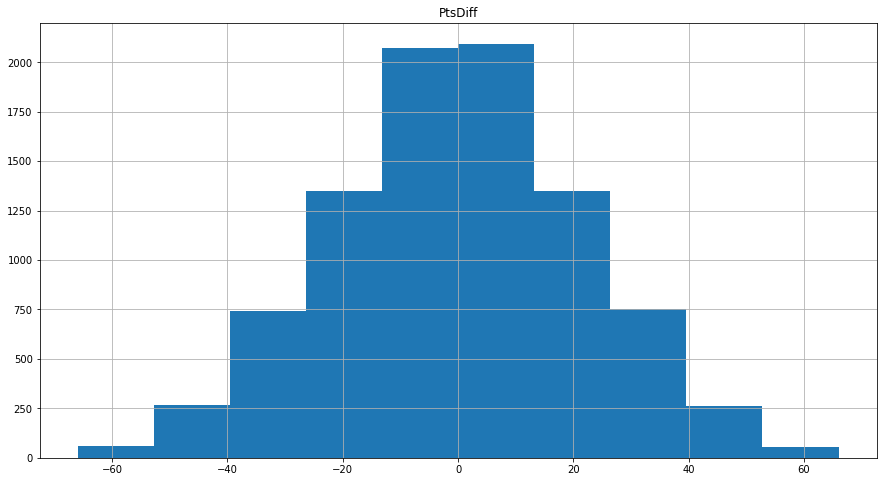

In [28]:
train_data.hist(column='PtsDiff', figsize=(15,8));

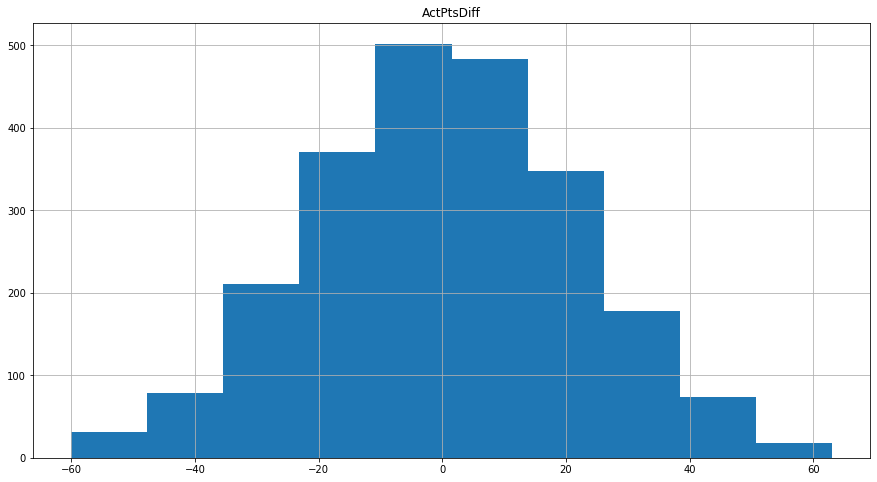

In [29]:
test.hist(column='ActPtsDiff', figsize=(15,8));

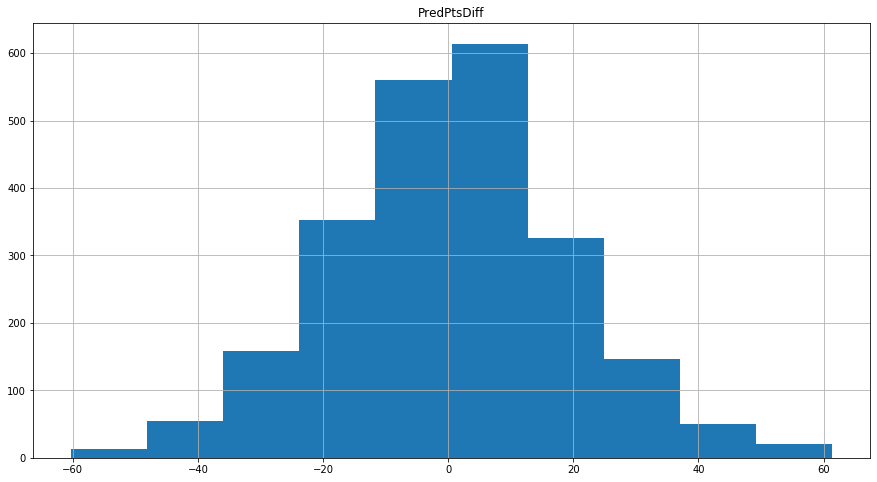

In [30]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [31]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [32]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -4.0 (exact value: -3.512915077833143)
Z score: -0.20556127406905994
Win Prob for Virginia Tech: 41.86%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.166667,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,-0.166667,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [33]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -13.0 (exact value: -12.536048585685663)
Z score: -0.6861545528468975
Win Prob for Georgia Tech: 24.63%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,-0.121075,0.018689,0.000768,0.0,0.0,0.166667,0.166667,0.0,4.750502,-0.498995
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,0.121075,-0.018689,-0.000768,0.0,0.0,-0.166667,-0.166667,0.0,5.249498,0.498995


In [34]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -1.0 (exact value: -0.5904337382323208)
Z score: -0.04990305534232862
Win Prob for Georgia Tech: 48.01%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.300725,0.012719,0.0,-0.133333,0.066667,0.0,0.0,1.0,5.012615,0.025231
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.300725,-0.012719,0.0,0.133333,-0.066667,0.0,0.0,-1.0,4.987385,-0.025231


In [35]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 4.0 (exact value: 3.9662094072869922)
Z score: 0.19279445851135635
Win Prob for Mississippi State: 57.64%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.070423,5.563380,0.880173,...,0.092249,0.000243,-0.004614,-0.666667,-0.333333,0.0,0.0,0,4.922257,-0.155486
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,-0.092249,-0.000243,0.004614,0.666667,0.333333,0.0,0.0,0,5.077743,0.155486


In [36]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -5.0 (exact value: -5.499568716158109)
Z score: -0.31137511191237793
Win Prob for Texas A&M: 37.78%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,-0.349878,0.001282,-0.047436,0.2,0.2,-0.25,-0.25,-0.25,5.109964,0.219927
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,0.349878,-0.001282,0.047436,-0.2,-0.2,0.25,0.25,0.25,4.890036,-0.219927


In [37]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Clemson,0.944602,13,12.0,1.0
2,Ohio State,0.942824,13,12.0,1.0
3,LSU,0.922250,13,12.0,1.0
4,Alabama,0.916620,12,11.0,1.0
5,Wisconsin,0.886764,13,12.0,1.0
...,...,...,...,...,...
126,Connecticut,0.097038,12,1.0,11.0
127,Rutgers,0.082030,12,1.0,11.0
128,Akron,0.076282,12,1.0,11.0
129,UMass,0.052627,12,1.0,11.0


In [38]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.573233,1.426767
21,Clemson,10.647896,2.352104
53,LSU,10.451588,2.548412
128,Wisconsin,9.737503,3.262497
78,Oklahoma,9.523050,3.476950
...,...,...,...
103,Texas State,2.050143,9.949857
25,Connecticut,1.846272,10.153728
1,Akron,1.758434,10.241566
112,UMass,1.332024,10.667976


In [39]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.557889,1
1,Florida State,2012,5.454605,2
2,BYU,2012,5.335653,3
3,Arizona State,2012,5.333539,4
4,Oklahoma,2012,5.331083,5
...,...,...,...,...
1025,Bowling Green,2019,4.525809,126
1026,Connecticut,2019,4.506369,127
1027,Rutgers,2019,4.450434,128
1028,Akron,2019,4.402725,129


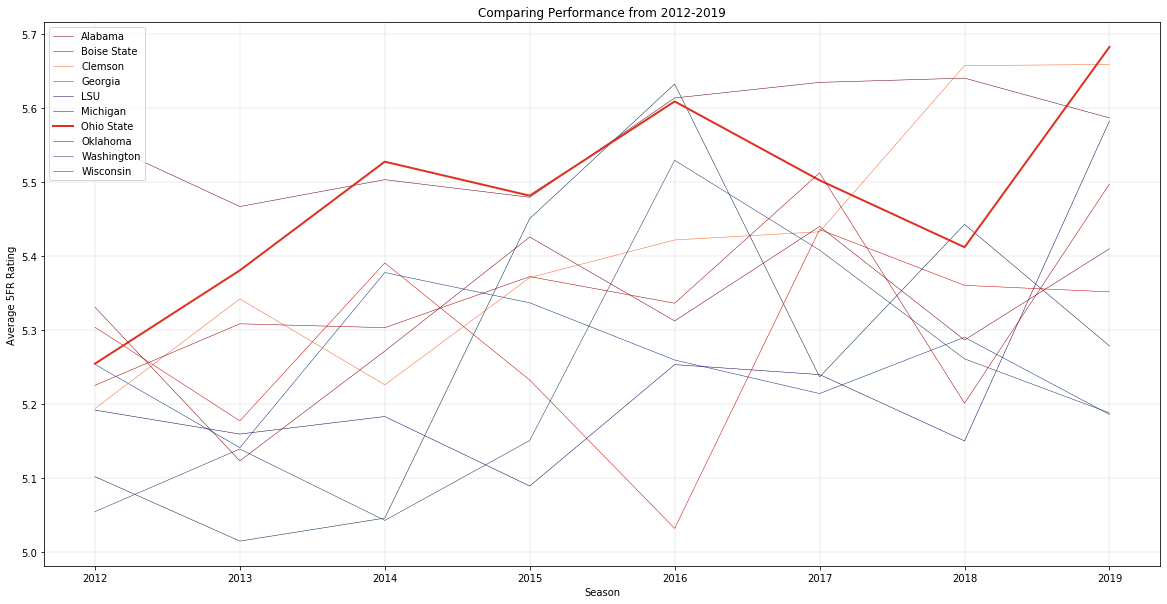

In [40]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [41]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

,Team,Avg5FR
0,Alabama,5.560512
1,Ohio State,5.481456
2,Clemson,5.413149
3,Wisconsin,5.344711
4,Oklahoma,5.325188
...,...,...
125,Georgia State,4.706279
126,UMass,4.678491
127,New Mexico State,4.678160
128,Coastal Carolina,4.621592


In [66]:
strength_max = team_strength.sort_values(by='5FR', ascending=False)
strength_max.head(10)

,Team,Season,5FR,Rank
900,Ohio State,2019,5.682812,1
127,Florida State,2013,5.667090,1
901,Clemson,2019,5.659044,2
770,Clemson,2018,5.657551,1
771,Alabama,2018,5.640608,2
640,Alabama,2017,5.634880,1
512,Michigan,2016,5.632687,1
513,Alabama,2016,5.613788,2
514,Ohio State,2016,5.609128,3
902,Alabama,2019,5.586845,3


In [67]:
strength_max[strength_max.Team == "Georgia Tech"]

,Team,Season,5FR,Rank
280,Georgia Tech,2014,5.189151,25
65,Georgia Tech,2012,5.002690,66
194,Georgia Tech,2013,4.998730,68
844,Georgia Tech,2018,4.984770,75
727,Georgia Tech,2017,4.918923,88
592,Georgia Tech,2016,4.894851,81
473,Georgia Tech,2015,4.827962,90
1018,Georgia Tech,2019,4.620667,119


In [43]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
...,...,...,...,...,...
11248,401117533.0,Nevada,2019.0,Wyoming,7.0
11249,401117541.0,Boise State,2019.0,Wyoming,8.0
11250,401117546.0,Utah State,2019.0,Wyoming,9.0
11251,401117550.0,Colorado State,2019.0,Wyoming,10.0


In [44]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech', 'Clemson', 2019, 0, -1)

[0.10813980143106966, -22.8684327344348]

In [45]:
team_triples = [
#     ['Buffalo', 'Charlotte', 7], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17], # App 31, UAB 17
#     ['UCF','Marshall',15], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
#     ['Miami','Louisiana Tech',6], # LaTech 14, Miami 0
#     ['Pittsburgh','Eastern Michigan',11], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
#     ['North Carolina','Temple',5], # UNC 55, Temple 13
#     ['Michigan State','Wake Forest',3.5], # MichSt 27, Wake 21
#     ['Texas A&M', 'Oklahoma State', 7], # TAMU 24, OKST 21
#     ['Iowa', 'USC', 2.5], # Iowa 48, USC 24
#     ['Air Force', 'Washington State', 3], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
#     ['Penn State','Memphis',7], # Cotton Bowl - PennSt 53, Memphis 39
#     ['Notre Dame', 'Iowa State', 4], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
#     ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
#     ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
#     ['Western Kentucky', 'Western Michigan', 3.5], # WKU 23, WMU 20
#     ['Mississippi State', 'Louisville', 4], # LOU 38, MSST 28
#     ['California', 'Illinois', 6.5], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
#     ['Florida','Virginia',14], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
#     ['Virginia Tech', 'Kentucky', 3], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
#     ['Arizona State', 'Florida State', 4],
#    ----- 19-8 SU / 14-13 ATS ------  
#     ['Navy', 'Kansas State', 2],
#    ----- 20-8 SU / 15-13 ATS ------  
#     ['Wyoming', 'Georgia State', 7],
#    ----- 21-8 SU / 15-14 ATS ------  
#     ['Utah', 'Texas', 7],
#    ----- 21-9 SU / 16-14 ATS ------     
#     ['Auburn', 'Minnesota', 7.5], # Minnesota 31, Auburn 24
#     ['Alabama', 'Michigan', 7], # Bama 35, Mich 16
#    ----- 23-9 SU / 17-15 ATS ------    
#     ['Wisconsin','Oregon',2.5], # Rose Bowl - Oregon 28, Wisc 27
#    ----- 23-10 SU / 18-15 ATS ------  
#     ['Georgia','Baylor',7.5], # Sugar Bowl - uga 26, Baylor 14
#    ----- 23-11 SU / 18-16 ATS ------      
    ['Cincinnati', 'Boston College',7],
    ['Tennessee', 'Indiana', 1.5],
    
    ['Ohio', 'Nevada', 7.5],
    
    ['Tulane', 'Southern Mississippi', 7],
    
    ['Louisiana', 'Miami (OH)', 14]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Cincinnati,Boston College,7.0,-6.449599,0.358685,False,Boston College,Boston College
0,Tennessee,Indiana,1.5,-1.561534,0.459527,False,Indiana,Indiana
0,Ohio,Nevada,7.5,6.929961,0.637075,False,Ohio,Nevada
0,Tulane,Southern Mississippi,7.0,-2.105103,0.448055,False,Southern Mississippi,Southern Mississippi
0,Louisiana,Miami (OH),14.0,-0.074037,0.491065,False,Miami (OH),Miami (OH)


In [46]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 0.0 (exact value: 0.3534228447790756)
Z score: 0.00036896263576415716
Win Prob for Virginia: 50.01%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,-0.403644,-0.089435,-0.044717,0.25,0.125,0.333333,0.333333,0.0,4.993899,-0.012203
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,0.403644,0.089435,0.044717,-0.25,-0.125,-0.333333,-0.333333,0.0,5.006101,0.012203


In [47]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 12.0 (exact value: 11.731146109878626)
Z score: 0.6063732209394251
Win Prob for North Carolina: 72.79%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.235394,0.079888,0.037736,0.238095,0.380952,-0.214286,-0.214286,0.5,5.231722,0.463445
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.235394,-0.079888,-0.037736,-0.238095,-0.380952,0.214286,0.214286,-0.5,4.768278,-0.463445


In [48]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 21.0 (exact value: 21.19153357383652)
Z score: 1.1102556721805075
Win Prob for Pittsburgh: 86.66%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,-0.248736,0.038746,0.026324,0.0,0.0,0.0,0.0,0.166667,5.419322,0.838645
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,0.248736,-0.038746,-0.026324,0.0,0.0,0.0,0.0,-0.166667,4.580678,-0.838645


In [49]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -11.0 (exact value: -10.721375705761114)
Z score: -0.5895008140417269
Win Prob for Auburn: 27.78%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,-0.083465,-0.033763,-0.013333,0.053571,0.160714,-0.666667,-0.666667,-0.5,5.213512,0.427025
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,0.083465,0.033763,0.013333,-0.053571,-0.160714,0.666667,0.666667,0.5,4.786488,-0.427025


In [50]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 38.0 (exact value: 37.9867712114055)
Z score: 2.0048094673856562
Win Prob for Georgia: 97.75%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,0.455922,0.020115,0.003352,0.888889,-0.111111,0.461538,0.461538,0.5,5.752373,1.504745
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,-0.455922,-0.020115,-0.003352,-0.888889,0.111111,-0.461538,-0.461538,-0.5,4.247627,-1.504745


In [51]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 24.0 (exact value: 24.063214654099866)
Z score: 1.2632081498056011
Win Prob for Clemson: 89.67%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 11.0 (exact value: 10.602383622049462)
Z score: 0.5462526802741285
Win Prob for Georgia Tech: 70.76%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -12.0 (exact value: -11.641309671348163)
Z score: -0.6384986572406358
Win Prob for The Citadel: 26.16%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 23.0 (exact value: 23.209370937846714)
Z score: 1.2177304284795405
Win Prob for Temple: 88.83%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 12.0 (exact value: 11.731146109878626)
Z score: 0.6063732209

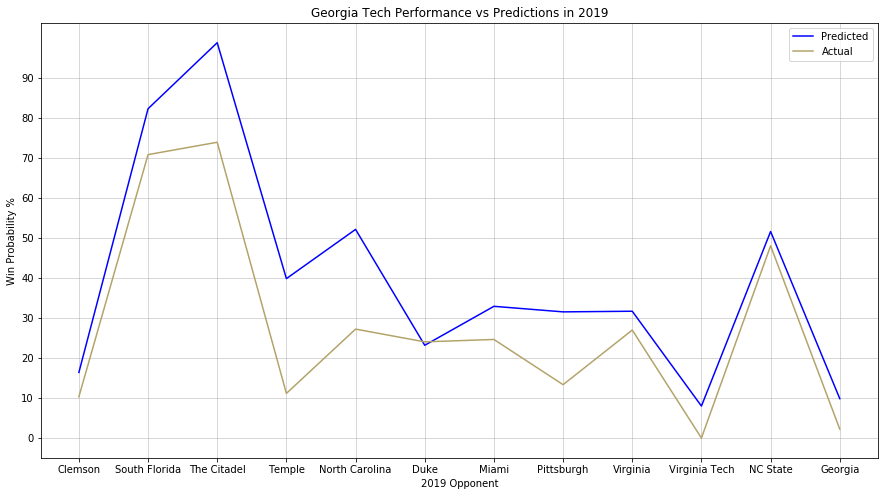

In [52]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

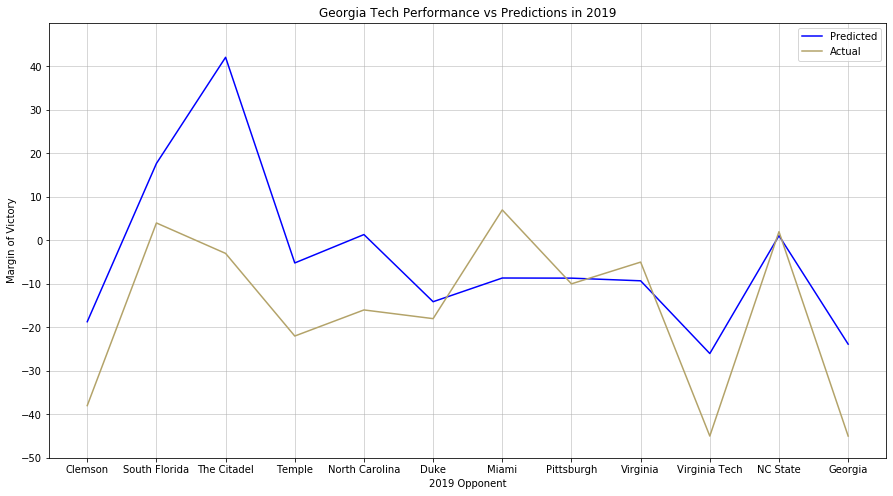

In [53]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 45.0 (exact value: 44.61389299805261)
Z score: 2.3577855355700654
Win Prob for Georgia Tech: 99.08%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 9.0 (exact value: 9.232900606887634)
Z score: 0.47331079906241824
Win Prob for South Florida: 68.20%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 8.0 (exact value: 7.998516461134402)
Z score: 0.4075646008749867
Win Prob for Pittsburgh: 65.82%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 39.0 (exact value: 38.60865312504831)
Z score: 2.037932358411278
Win Prob for Clemson: 97.92%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 43.0 (exact value: 42.72912800925019)
Z score:

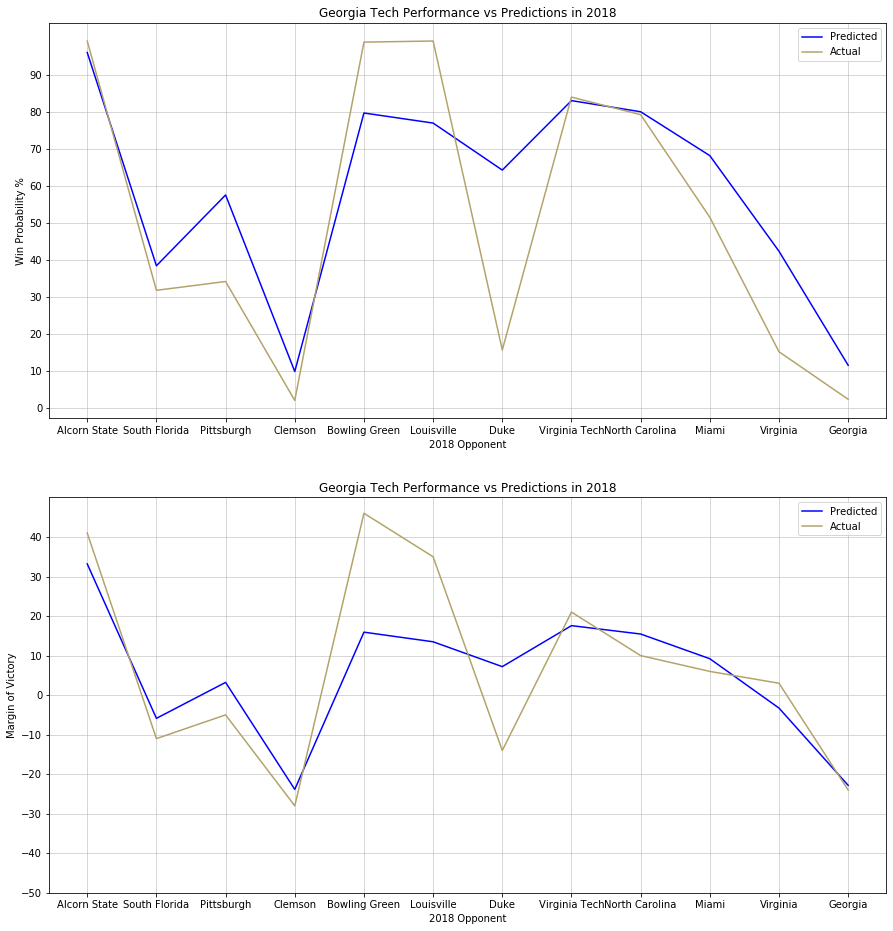

In [54]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

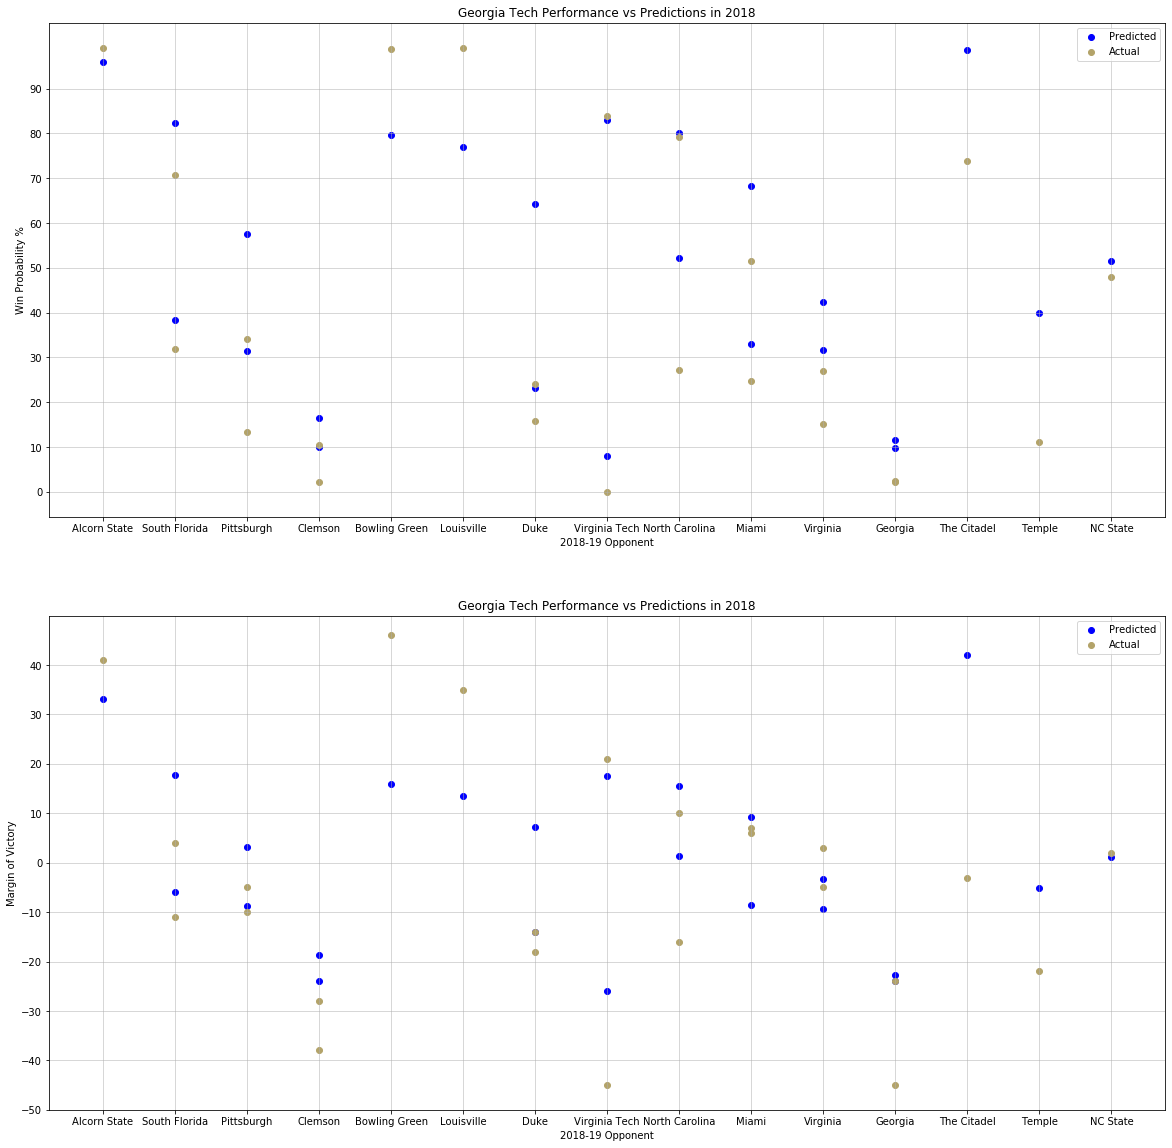

In [55]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [56]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019
Season,,,,,,,,
2012,1.000000,0.588419,0.525922,0.451708,0.382888,0.294932,0.300102,0.363724
2013,0.588419,1.000000,0.562660,0.366535,0.245886,0.260429,0.185906,0.279529
2014,0.525922,0.562660,1.000000,0.616191,0.486516,0.332863,0.332074,0.386088
2015,0.451708,0.366535,0.616191,1.000000,0.656791,0.472449,0.379352,0.403569
2016,0.382888,0.245886,0.486516,0.656791,1.000000,0.602822,0.417091,0.594267
2017,0.294932,0.260429,0.332863,0.472449,0.602822,1.000000,0.634953,0.569375
2018,0.300102,0.185906,0.332074,0.379352,0.417091,0.634953,1.000000,0.610008
2019,0.363724,0.279529,0.386088,0.403569,0.594267,0.569375,0.610008,1.000000


In [57]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["UCF","Auburn","James Madison","Connecticut","Boston College","Duke","Miami","Georgia Tech","NC State","Pittsburgh","Virginia Tech","Virginia"],
    "Site" : ["Away","Home","Home","Home","Away","Away","Away","Home","Home","Home","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("North Carolina", opp_2020_df, 2020)
georgia_tech_2020

,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,North Carolina,UCF,Away,34.357322,-7.214766
1,2020,North Carolina,Auburn,Home,26.241538,-11.592832
2,2020,North Carolina,James Madison,Home,98.962530,43.763913
3,2020,North Carolina,Connecticut,Home,78.010607,14.851141
4,2020,North Carolina,Boston College,Away,44.964422,-2.029672
5,2020,North Carolina,Duke,Away,47.867545,-0.657557
6,2020,North Carolina,Miami,Away,35.388995,-6.691110
7,2020,North Carolina,Georgia Tech,Home,61.024748,5.602819
8,2020,North Carolina,NC State,Home,56.613250,3.473211
9,2020,North Carolina,Pittsburgh,Home,47.486779,-0.837058


In [58]:
generate_win_prob(401135288, 2019)
box2 = calculate_box_score(401135288, 2019)
# testDiffs = ["Team",'5FRDiff']
# print(box2[["Team","FP","FPDiff"]])
break_down_box_score(box2)

Could not find basic game data for game_id 401135288 locally, checking CFB Data API
Could not find drive data for game_id 401135288 locally, checking CFB Data API
Could not find play by play data for game_id 401135288 locally, checking CFB Data API
Game: Oregon @ Wisconsin
Actual Winner: Oregon
MOV: Oregon by 1
Proj MOV: Oregon by 4.0 (exact value: 4.328273895773731)
Z score: 0.21207886336909576
Win Prob for Oregon: 58.40%
---
Could not find basic game data for game_id 401135288 locally, checking CFB Data API
Could not find drive data for game_id 401135288 locally, checking CFB Data API
Could not find play by play data for game_id 401135288 locally, checking CFB Data API


,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Oregon,5.114379,4.947433,4.87236,5.115385,5.68268,5.084923,0.169846
1,Wisconsin,4.885621,5.052567,5.12764,4.884615,4.31732,4.915077,-0.169846


In [59]:
predict_matchup("Oregon","Wisconsin", 2012, -1)

[0.3931690975818958, -4.742816258362509]

In [60]:
line_data = pd.DataFrame()

for i in range(2013, 2020):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")

Spreads imported: 17274


In [61]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week)[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week)[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam, "AwayScore": lines.awayScore,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [62]:
historic_validation = pd.DataFrame()
for i in range(2013, 2020):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 700 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 692 games with betting lines for 2013 season.
[Simulation] Creating projections for 692 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 697 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 648 games with betting lines for 2014 season.
[Simulation] Creating projections for 648 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 709 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 675 games with betting lines for 2015 season.
[Simulation] Creating projections for 675 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

,pick_category,season,W,L,D,WinPct
0,ML,2013,536,156,0,0.774566
1,ATS,2013,382,302,8,0.552023
0,ML,2014,502,146,0,0.774691
1,ATS,2014,406,226,16,0.626543
0,ML,2015,533,142,0,0.789630
1,ATS,2015,407,250,18,0.602963
0,ML,2016,523,153,0,0.773669
1,ATS,2016,403,255,18,0.596154
0,ML,2017,562,158,0,0.780556
1,ATS,2017,421,279,20,0.584722


In [63]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.7743314110629581
Avg ATS Win %: 0.5894258467716877


In [64]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [65]:
break_down_box_score(calculate_box_score(401136253, 2019))

Could not find basic game data for game_id 401136253 locally, checking CFB Data API
Could not find drive data for game_id 401136253 locally, checking CFB Data API
Could not find play by play data for game_id 401136253 locally, checking CFB Data API


,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,USC,4.574315,4.991125,3.767605,3.345385,4.281296,4.426156,-1.147687
1,Iowa,5.425685,5.008875,6.232395,6.654615,5.718704,5.573844,1.147687
